In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn

import pyro
from pyro.nn import PyroParam, PyroSample, PyroModule
import pyro.distributions as dist
from pyro.distributions.torch import Bernoulli
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine

plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset 

In [2]:
wind_df = pd.read_csv("/mnt/dl/machine_learning_dataset/wind_speed_prediction_dataset/wind_dataset.csv")

In [3]:
wind_df

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5
...,...,...,...,...,...,...,...,...,...
6569,1978-12-27,14.46,0,16.8,0.0,9.8,0.0,4.0,0.0
6570,1978-12-28,14.33,0,16.0,0.0,9.1,0.0,8.5,8.0
6571,1978-12-29,19.17,0,14.7,0.0,5.0,0.0,3.5,3.2
6572,1978-12-30,18.08,0,4.9,0.0,2.9,0.0,0.3,-0.5


In [4]:
wind_df.dropna(inplace=True)

In [5]:
x = wind_df[['IND', 'RAIN', 'IND.1', 'T.MAX', 'IND.2', 'T.MIN', 'T.MIN.G']].to_numpy()
y = wind_df['WIND'].to_numpy()

In [6]:
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

In [7]:
x

tensor([[ 0.0000,  0.2000,  0.0000,  ...,  0.0000,  3.7000, -1.0000],
        [ 0.0000,  5.1000,  0.0000,  ...,  0.0000,  4.2000,  1.1000],
        [ 0.0000,  0.4000,  0.0000,  ...,  0.0000,  0.5000, -0.5000],
        ...,
        [ 0.0000, 14.7000,  0.0000,  ...,  0.0000,  3.5000,  3.2000],
        [ 0.0000,  4.9000,  0.0000,  ...,  0.0000,  0.3000, -0.5000],
        [ 0.0000,  0.5000,  0.0000,  ...,  1.0000, -1.5000, -3.0000]])

In [8]:
y

tensor([13.6700, 11.5000, 11.2500,  ..., 19.1700, 18.0800, 19.2500])

In [9]:
## Linear Model

class LinearModel(nn.Module):
    
    def __init__(self, indim):
        super().__init__()
        
        hdim = 32
        self.net = nn.Sequential(
            nn.Linear(indim, hdim, bias=True),
            nn.ReLU(),
            nn.Linear(hdim, 1, bias=True),
        )
        self.apply(self.reset_parameters)
    
    @staticmethod
    def reset_parameters(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.)
        
    def forward(self, x):
        return self.net(x).squeeze()
        

In [10]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [11]:
(x - x.mean(0)) / (x.var(0) + 1e-8)

tensor([[-0.2824, -0.1061, -0.5067,  ..., -1.0184, -0.1283, -0.1208],
        [-0.2824,  0.2042, -0.5067,  ..., -1.0184, -0.1050, -0.0533],
        [-0.2824, -0.0934, -0.5067,  ..., -1.0184, -0.2778, -0.1047],
        ...,
        [-0.2824,  0.8121, -0.5067,  ..., -1.0184, -0.1377,  0.0142],
        [-0.2824,  0.1915, -0.5067,  ..., -1.0184, -0.2872, -0.1047],
        [-0.2824, -0.0871, -0.5067,  ...,  9.8353, -0.3712, -0.1851]])

In [12]:
lin_net = LinearModel(7)
lin_net.cuda()

# inp = x.cuda()
inp = (x - x.mean(0)) / (x.var(0) + 1e-8)
inp = inp.cuda()
out = y.cuda()
optimizer = torch.optim.Adam(lin_net.parameters(), lr=5e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
epochs = 1000
losses = []
criterion = nn.MSELoss()
for i in range(epochs):
    net_out = lin_net(inp)
    loss = criterion(net_out, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    
    

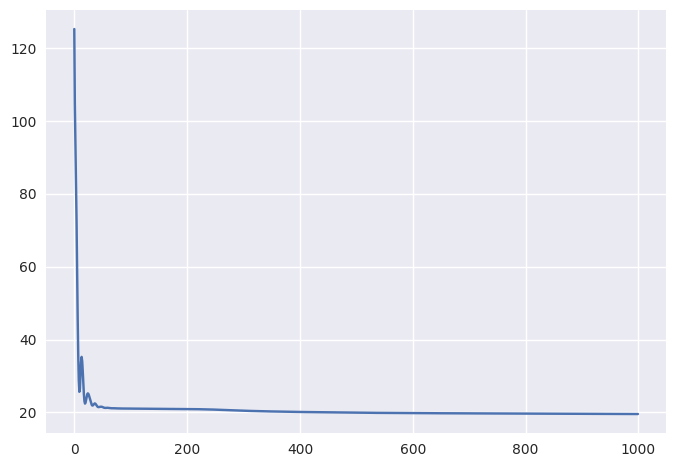

In [13]:
plt.plot(losses)

In [14]:
net_out

tensor([10.4230, 12.8120, 13.0628,  ..., 15.1093, 15.7815, 10.6805],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [15]:
out

tensor([13.6700, 11.5000, 11.2500,  ..., 19.1700, 18.0800, 19.2500],
       device='cuda:0')

In [16]:
scheduler.get_last_lr()

[0.006753226122334176]

In [17]:
## Bayesian Linear Model


class BayesianLinear(pyro.nn.PyroModule):
    
    def __init__(self, in_dim, out_dim, bias=True):
        super().__init__()
        
        self.weight_loc = PyroParam(torch.zeros(in_dim, out_dim))
        self.weight_scale = PyroParam(torch.ones(in_dim, out_dim), constraint=constraints.positive)
        
        self.bias_loc = PyroParam(torch.zeros(out_dim, ))
        self.bias_scale = PyroParam(torch.ones(out_dim), constraint=constraints.positive)
        
        self.weight = PyroSample(lambda self: dist.Normal(self.weight_loc, self.weight_scale).to_event(2))
        if bias:
            self.bias = PyroSample(lambda self: dist.Normal(self.bias_loc, self.bias_scale).to_event(1))
        else:
            self.bias = None
    
    def forward(self, x):
        out = x @ self.weight 
        if self.bias is not None:
            out += self.bias
        return out
    

In [18]:
bay_net = BayesianLinear(5, 3).cuda()

In [19]:
bay_net.weight

tensor([[-0.9247, -0.4253, -2.6438],
        [ 0.1452, -0.1209, -0.5797],
        [-0.6229, -0.3284, -1.0745],
        [-0.3631, -1.6711,  2.2655],
        [ 0.3117, -0.1842,  1.2866]], device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
bay_net.weight

tensor([[ 0.1808, -0.5523,  0.9238],
        [-0.7350,  1.3800,  0.8676],
        [ 0.1297, -0.9406,  0.8109],
        [ 0.8821, -1.0133, -0.3634],
        [ 0.5101,  0.4179, -0.6888]], device='cuda:0', grad_fn=<AddBackward0>)

In [21]:
bay_net.bias_scale

tensor([1., 1., 1.], device='cuda:0', grad_fn=<AddBackward0>)

In [22]:
bay_net.bias_scale

tensor([1., 1., 1.], device='cuda:0', grad_fn=<AddBackward0>)

In [23]:
bay_net(torch.randn(2, 5).cuda())

tensor([[ 1.0177, -0.9609, -4.3574],
        [ 1.5258, -1.3349, -1.7212]], device='cuda:0', grad_fn=<AddBackward0>)

In [24]:

## Linear Model

class BayesianRegModel(PyroModule):
    
    def __init__(self, indim):
        super().__init__()
        
        hdim = 32
        self.net = PyroModule[nn.Sequential](
            BayesianLinear(indim, hdim, bias=True),
            PyroModule[nn.ReLU](),
            BayesianLinear(hdim, 1, bias=True),
        )
    
    def forward(self, x):
        return self.net(x).squeeze()
    

In [25]:
lin_net = BayesianRegModel(7)
lin_net.cuda()

inp = (x - x.mean(0)) / (x.var(0) + 1e-8)
inp = inp.cuda()
out = y.cuda()
optimizer = pyro.optim.Adam({"lr": 6e-3})
epochs = 1000
losses = []
    

In [33]:
optimizer = torch.optim.Adam(lin_net.parameters(), lr=5e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.998)
epochs = 1000
losses = []
criterion = nn.MSELoss()
for i in range(epochs):
    net_out = lin_net(inp)
    loss = criterion(net_out, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

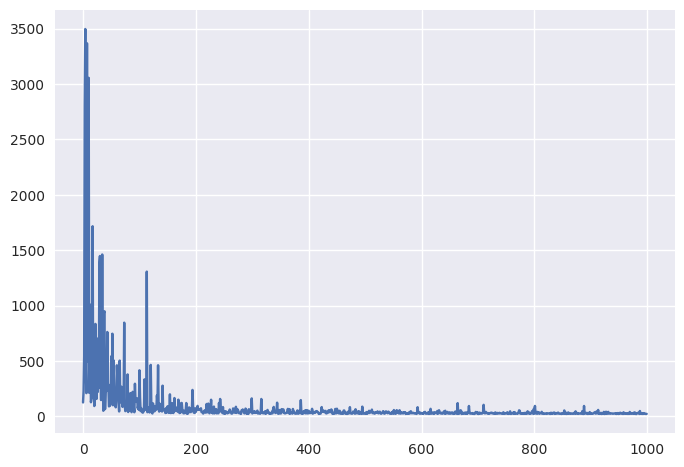

In [35]:
plt.plot(losses)

In [37]:
out

tensor([13.6700, 11.5000, 11.2500,  ..., 19.1700, 18.0800, 19.2500],
       device='cuda:0')

In [38]:
lin_net(inp)

tensor([ 9.2954, 10.8684, 11.3697,  ..., 12.2123, 12.8305,  2.7245],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [40]:
lin_net(inp)

tensor([11.0944, 12.8058, 13.3024,  ..., 15.3027, 14.7507, 11.0134],
       device='cuda:0', grad_fn=<SqueezeBackward0>)